In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch 
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.linear_model import SGDOneClassSVM
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, accuracy_score
from tqdm import tqdm, trange

from dataset import Dataset, get_transac_n_seconds
from models import Classifier, Projector, VAE
from trainers.drocc_trainer import DROCCTrainer, adjust_learning_rate
from trainers.dsvdd_trainer import DeepSVDD
from trainers.vae_trainer import LossVAE

In [77]:
#df = pd.read_csv('~/Bureau/Datasets/TimeSeries/creditcard.csv')
df = pd.read_csv('creditcard.csv')
df.head()

DEVICE="mps"
BATCH_SIZE=256

THRESHOLD=0.01

In [78]:
normal_rate = len(df[df['Class']==0])/ len(df)
anormal_rate = len(df[df['Class']==1])/ len(df)

print(f"normal rate: {normal_rate} ; anormal rate: {anormal_rate}")

normal rate: 0.9982725143693799 ; anormal rate: 0.001727485630620034


# Supervised Setting

In [79]:
dataset = get_transac_n_seconds(df, seconds=1) # Takes 30 sec approx

train_size = int(0.75*len(dataset))

training = dataset.iloc[:train_size]
test = dataset.iloc[train_size:]

train_size = int(0.8*len(training))

train = training.iloc[:train_size]
val = training.iloc[train_size:]

scaler = StandardScaler()

train = train.copy()
val = val.copy()
test = test.copy()

print(f'Train len: {len(train)}')
print(f'Val len: {len(val)}')
print(f'Test len: {len(test)}')

train['Amount'] = scaler.fit_transform(train['Amount'].values.reshape(-1, 1))
val['Amount'] = scaler.transform(val['Amount'].values.reshape(-1, 1))
test['Amount'] = scaler.transform(test['Amount'].values.reshape(-1, 1))

Train len: 170884
Val len: 42721
Test len: 71202


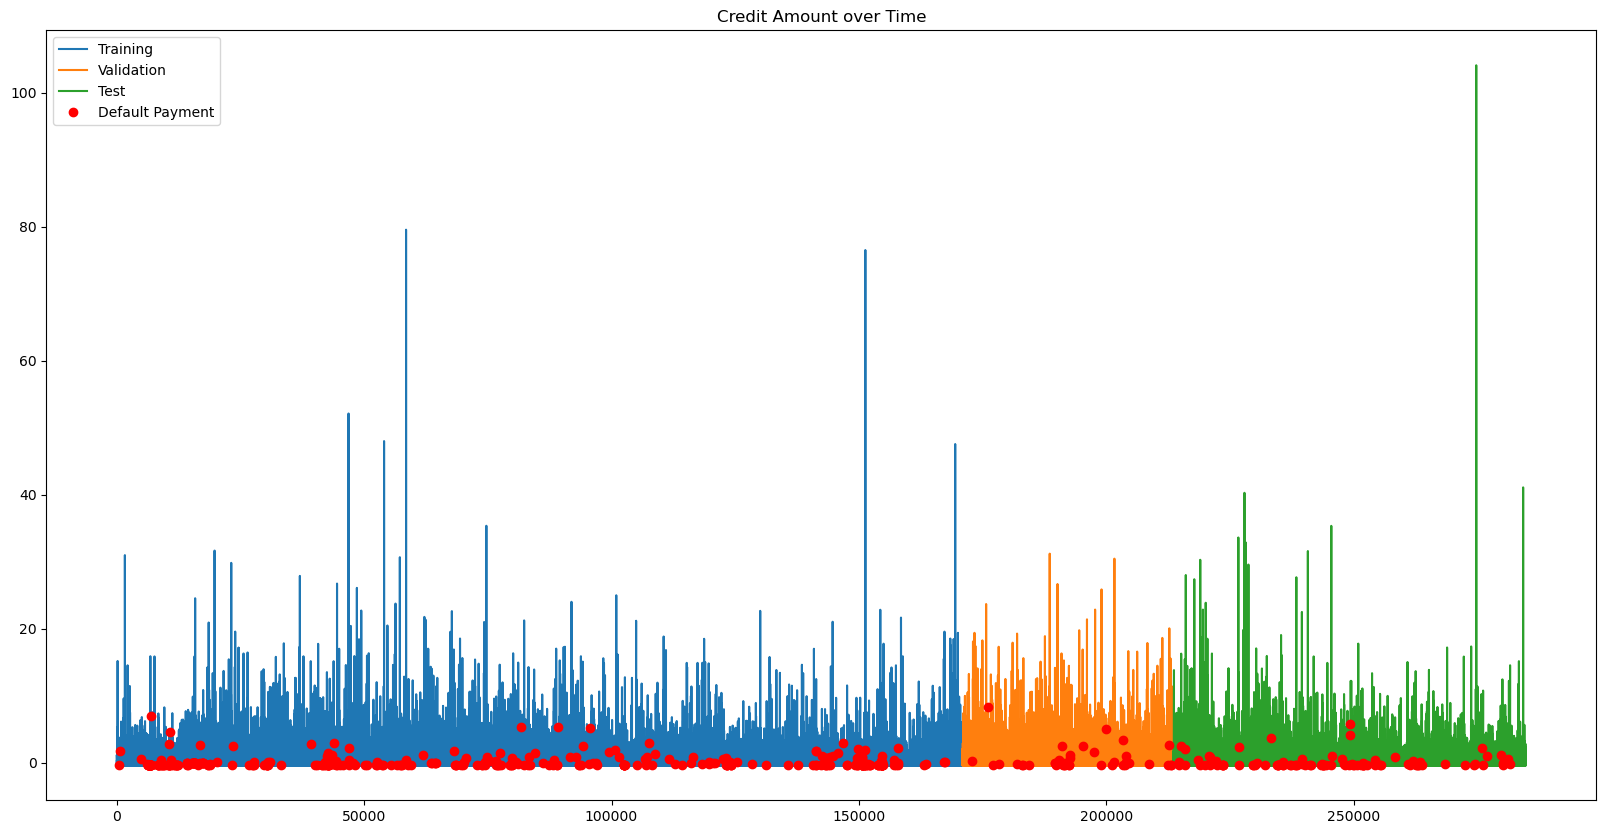

In [7]:
plt.figure(figsize=(20, 10))

ano_tr_indices = [i for i in train[train['Class']==1].index]
ano_val_indices = [i for i in val[val['Class']==1].index]
ano_test_indices = [i for i in test[test['Class']==1].index]

plt.plot(train.index, train['Amount'], label='Training')
plt.plot(val.index, val['Amount'], label='Validation')
plt.plot(test.index, test['Amount'], label='Test')
plt.plot(ano_tr_indices, train.loc[ano_tr_indices, "Amount"], "ro", label="Default Payment")
plt.plot(ano_val_indices, val.loc[ano_val_indices, "Amount"], "ro")
plt.plot(ano_test_indices, test.loc[ano_test_indices, "Amount"], "ro")
plt.title("Credit Amount over Time")
plt.legend()

### Basic DNN Classifier

In [8]:
BATCH_SIZE=256
EPOCHS=2
LR=1e-3

In [9]:
trainset = Dataset(train)
valset = Dataset(val)
testset = Dataset(test)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = Classifier().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [10]:
for epoch in range(EPOCHS):
    epoch_loss = 0
    batch_pbar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{EPOCHS} Batches", leave=False)  # Inner progress bar for batches
    for inputs, targets in batch_pbar:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        # Forward pass
        preds = model(inputs)
        preds = torch.squeeze(preds, dim=1)
        targets = targets.float()
        loss = criterion(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

        # Optionally update the inner pbar with the current loss
        batch_pbar.set_postfix(loss=loss.item())

    # Optionally update the outer pbar with the epoch loss
    print(f"epoch loss : {loss.item()/len(trainloader)}")

epoch loss : 2.4180171640400223e-06


epoch loss : 8.662159988255112e-07


In [11]:
val_preds = []
val_tar = []

model.eval()
with torch.no_grad():
    for val_batch, targets in tqdm(valloader, leave=True):
        val_batch, targets = val_batch.to(DEVICE), targets.to(DEVICE)
        preds = model(val_batch).squeeze()
        preds = torch.sigmoid(preds)
        val_preds.append(preds.cpu())
        val_tar.append(targets.cpu())

val_tar = torch.cat(val_tar)
val_preds = torch.cat(val_preds)

100%|██████████| 167/167 [00:00<00:00, 288.49it/s]


In [12]:
all_preds = []
all_tar = []

model.eval()
with torch.no_grad():
    for test_batch, targets in tqdm(testloader, leave=True):
        test_batch, targets = test_batch.to(DEVICE), targets.to(DEVICE)
        preds = model(test_batch).squeeze()
        preds = torch.sigmoid(preds)
        all_preds.append(preds.cpu())
        all_tar.append(targets.cpu())

all_tar = torch.cat(all_tar)
all_preds = torch.cat(all_preds)

score_supervised = roc_auc_score(all_tar, all_preds)
print(f"ROC-AUC score: {score_supervised}")

100%|██████████| 279/279 [00:00<00:00, 334.54it/s]

ROC-AUC score: 0.9460745357077457


In [13]:
test_p_values = (1 + torch.sum(all_preds.unsqueeze(1) >= val_preds, dim=1)) / (len(val_preds) + 1)
conserved = test_p_values>=THRESHOLD

supervised_f1 = f1_score(all_tar, conserved)
supervised_recall = recall_score(all_tar, conserved)
supervised_precision = precision_score(all_tar, conserved)
supervised_accuracy = accuracy_score(all_tar, conserved)

print(f"f1: {supervised_f1}")
print(f"recall: {supervised_recall}")
print(f"precision: {supervised_precision}")
print(f"accuracy: {supervised_accuracy}")

f1: 0.9941239278466423
recall: 0.988566687292569
precision: 0.9997440018204315
accuracy: 0.9883289795230471


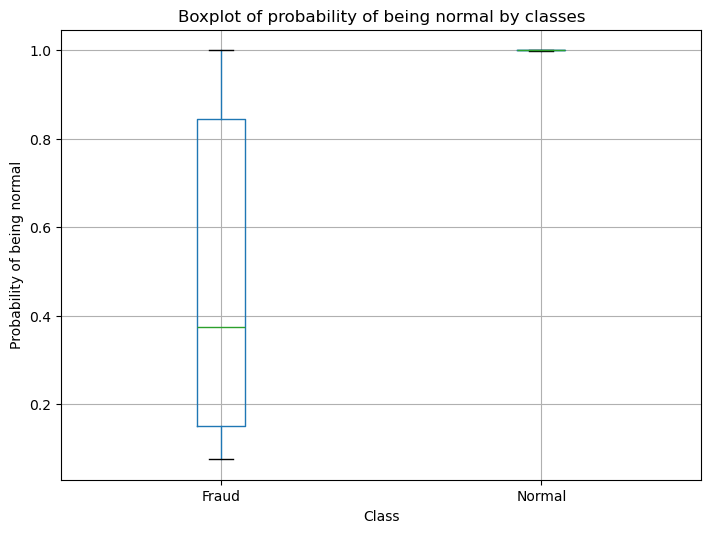

In [14]:
results = pd.DataFrame({})
results["pred"] = all_preds
results['class']=all_tar

results.boxplot(column='pred', by='class', figsize=(8, 6), showfliers=False)

plt.title("Boxplot of probability of being normal by classes")
plt.suptitle("") 
plt.xlabel("Class")
plt.ylabel("Probability of being normal")
plt.xticks(ticks=[1, 2], labels=['Fraud', 'Normal'])

plt.show()

### Gradient Boosting

In [68]:
X_train = train.drop(['Time', 'Class'], axis=1)
X_val = val.drop(['Time', 'Class'], axis=1)
X_test = test.drop(['Time', 'Class'], axis=1)

y_train = train['Class']
y_val = train['Class']
y_test = test['Class']

In [69]:
clf = CatBoostClassifier().fit(X_train, y_train, verbose=False)
val_probs = clf.predict_proba(X_val) # First column proba normal, second proba anormal
test_probs = clf.predict_proba(X_test) # First column proba normal, second proba anormal

In [70]:
score_catboost = roc_auc_score(y_test, test_probs[:,1])
print(f"ROC-AUC score: {score_catboost}")

ROC-AUC score: 0.9693069517270104


In [71]:
val_probs = val_probs[:,0].squeeze()
test_probs = test_probs[:,0].squeeze()

test_p_values = (1 + np.sum(test_probs.reshape(-1, 1) >= val_probs, axis=1)) / (len(val_probs) + 1)
conserved = test_p_values>=THRESHOLD

boost_f1 = f1_score(1-y_test, conserved)
boost_recall = recall_score(1-y_test, conserved)
boost_precision = precision_score(1-y_test, conserved)
boost_accuracy = accuracy_score(1-y_test, conserved)

print(f"f1: {boost_f1}")
print(f"recall: {boost_recall}")
print(f"precision: {boost_precision}")
print(f"accuracy: {boost_accuracy}")

f1: 0.9958350393200526
recall: 0.991927771840018
precision: 0.9997732104890149
accuracy: 0.9917137159068565


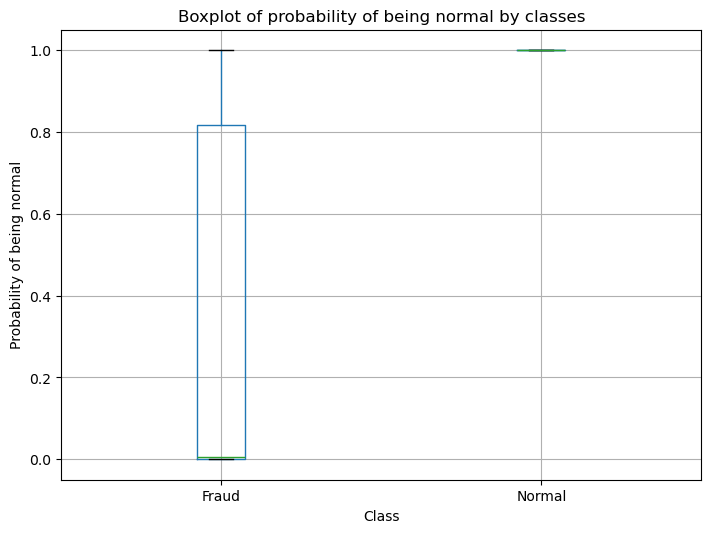

In [75]:
results = pd.DataFrame({})
results["pred"] = test_probs
results['class']=1-y_test.values

results.boxplot(column='pred', by='class', figsize=(8, 6), showfliers=False)

plt.title("Boxplot of probability of being normal by classes")
plt.suptitle("") 
plt.xlabel("Class")
plt.ylabel("Probability of being normal")
plt.xticks(ticks=[1, 2], labels=['Fraud', 'Normal'])

plt.show()

# Unsupervised Setting

In [13]:
dataset = df.copy()

train_size = int(0.75*len(dataset))
train = dataset.iloc[:train_size]
test = dataset.iloc[train_size:]
train = train[train['Class'] == 0]

new_train_size = len(train)

dataset = pd.concat([train, test], ignore_index=True)
dataset = get_transac_n_seconds(dataset, seconds=2)

training = dataset.iloc[:new_train_size]
test = dataset.iloc[new_train_size:]

train_size = int(0.8*len(train))

train = training.iloc[:train_size]
val = training.iloc[train_size:]

scaler = StandardScaler()

train = train.copy()
val = val.copy()
test = test.copy()

print(f'Train len: {len(train)}')
print(f'Val len: {len(val)}')
print(f'Test len: {len(test)}')

train['Amount'] = scaler.fit_transform(train['Amount'].values.reshape(-1, 1))
val['Amount'] = scaler.transform(val['Amount'].values.reshape(-1, 1))
test['Amount'] = scaler.transform(test['Amount'].values.reshape(-1, 1))

Train len: 170565
Val len: 42642
Test len: 71202


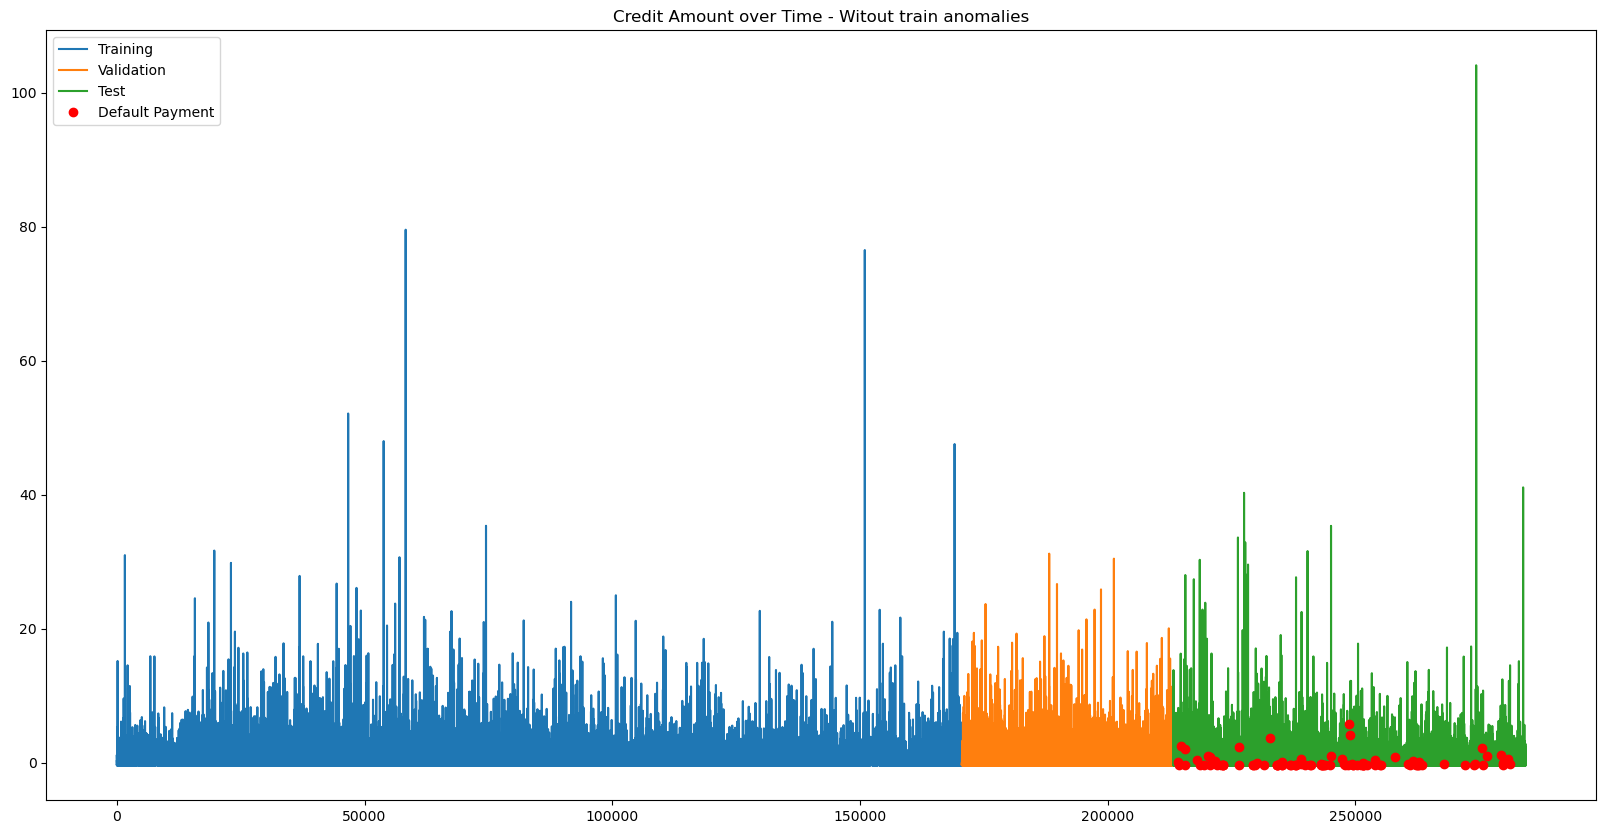

In [14]:
plt.figure(figsize=(20, 10))

anomalies_indices = [i for i in test[test['Class']==1].index]

plt.plot(train.index, train['Amount'], label='Training')
plt.plot(val.index, val['Amount'], label='Validation')
plt.plot(test.index, test['Amount'], label='Test')
plt.plot(anomalies_indices, test.loc[anomalies_indices, "Amount"], "ro", label="Default Payment")
plt.title("Credit Amount over Time - Witout train anomalies")
plt.legend()

### Deep SVDD

In [20]:
LR=1e-3
EPOCHS=10
BATCH_SIZE=256
WEIGHT_DECAY=1e-6
PROJ_DIM=32

In [21]:
model = Projector(proj_dim=PROJ_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0], gamma=0.1)

In [22]:
svdd = DeepSVDD(model=model, proj_dim=PROJ_DIM, device=DEVICE)
center = svdd.initialize_center(trainloader=trainloader)
results = svdd.train(trainloader=trainloader, epochs=EPOCHS, optimizer=optimizer, scheduler=scheduler)

model = results["model"]
center = results["center"]

Training: 100%|██████████| 668/668 [00:01<00:00, 402.02it/s]


Epoch 1/10 ; Loss: 0.8946


Training: 100%|██████████| 668/668 [00:01<00:00, 388.79it/s]


Epoch 2/10 ; Loss: 0.2824


Training: 100%|██████████| 668/668 [00:01<00:00, 429.13it/s]


Epoch 3/10 ; Loss: 0.1635


Training: 100%|██████████| 668/668 [00:01<00:00, 394.98it/s]


Epoch 4/10 ; Loss: 0.1127


Training: 100%|██████████| 668/668 [00:01<00:00, 432.76it/s]


Epoch 5/10 ; Loss: 0.0820


Training: 100%|██████████| 668/668 [00:01<00:00, 409.30it/s]


Epoch 6/10 ; Loss: 0.0609


Training: 100%|██████████| 668/668 [00:01<00:00, 417.04it/s]


Epoch 7/10 ; Loss: 0.0459


Training: 100%|██████████| 668/668 [00:01<00:00, 405.58it/s]


Epoch 8/10 ; Loss: 0.0353


Training: 100%|██████████| 668/668 [00:01<00:00, 423.45it/s]


Epoch 9/10 ; Loss: 0.0277


Training: 100%|██████████| 668/668 [00:01<00:00, 399.04it/s]

Epoch 10/10 ; Loss: 0.0222


In [23]:
val_preds = []
val_tar = []

model.eval()
with torch.no_grad():
    for val_batch, targets in tqdm(valloader, leave=True):
        val_batch, targets = val_batch.to(DEVICE), targets.to(DEVICE)
        proj = model(val_batch)
        dist = torch.sum((proj - center) ** 2, dim=1)
        val_preds.append(-dist.cpu())
        val_tar.append(targets.cpu())

val_tar = torch.cat(val_tar)
val_preds = torch.cat(val_preds)

100%|██████████| 167/167 [00:00<00:00, 524.97it/s]


In [24]:
all_preds = []
all_tar = []

model.eval()
with torch.no_grad():
    for test_batch, targets in tqdm(testloader, leave=True):
        test_batch, targets = test_batch.to(DEVICE), targets.to(DEVICE)
        proj = model(test_batch)
        dist = torch.sum((proj - center) ** 2, dim=1)
        all_preds.append(-dist.cpu())
        all_tar.append(targets.cpu())

all_tar = torch.cat(all_tar)
all_preds = torch.cat(all_preds)

score_dsvdd = roc_auc_score(all_tar, all_preds)
print(f"ROC-AUC score: {score_dsvdd}")

100%|██████████| 279/279 [00:00<00:00, 521.56it/s]

ROC-AUC score: 0.9502568164218886


In [26]:
test_p_values = (1 + torch.sum(all_preds.unsqueeze(1) >= val_preds, dim=1)) / (len(val_preds) + 1)
conserved = test_p_values>=THRESHOLD

dsvdd_f1 = f1_score(all_tar, conserved)
dsvdd_recall = recall_score(all_tar, conserved)
dsvdd_precision = precision_score(all_tar, conserved)
dsvdd_accuracy = accuracy_score(all_tar, conserved)

print(f"f1: {dsvdd_f1}")
print(f"recall: {dsvdd_recall}")
print(f"precision: {dsvdd_precision}")
print(f"accuracy: {dsvdd_accuracy}")

f1: 0.9957792207792208
recall: 0.9920262136468471
precision: 0.9995607323017628
accuracy: 0.9916013595123733


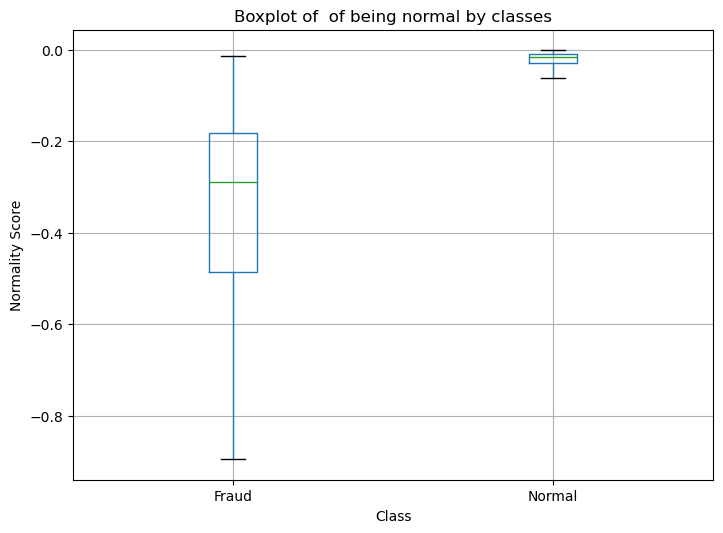

In [27]:
results = pd.DataFrame({})
results["pred"] = all_preds
results['class']=all_tar

results.boxplot(column='pred', by='class', figsize=(8, 6), showfliers=False)

# Ajouter des labels et un titre
plt.title("Boxplot of  of being normal by classes")
plt.suptitle("")  # Supprime le titre automatique de pandas
plt.xlabel("Class")
plt.ylabel("Normality Score")
plt.xticks(ticks=[1, 2], labels=['Fraud', 'Normal'])

# Afficher le graphique
plt.show()

### DROCC

In [28]:
LR=1e-3
EPOCHS=4
BATCH_SIZE=256

CE_EPOCHS=1
ASCENT_STEP_SIZE=0.1
ASCENT_NUM_STEPS=50

GAMMA=2
LAMBDA=1
RADIUS=5

In [29]:
model = Classifier().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [30]:
trainer = DROCCTrainer(model, optimizer, lamda=LAMBDA, radius=RADIUS, gamma=GAMMA, device=DEVICE)
trainer.train(trainloader, learning_rate=LR, lr_scheduler=adjust_learning_rate, total_epochs=EPOCHS,
             ascent_step_size=ASCENT_STEP_SIZE, ascent_num_steps=ASCENT_NUM_STEPS, only_ce_epochs = CE_EPOCHS)

model = trainer.get_model()

100%|██████████| 668/668 [00:01<00:00, 393.10it/s]


Epoch: 0, CE Loss: 0.03731776028871536, AdvLoss: 0.0


100%|██████████| 668/668 [00:15<00:00, 42.37it/s]


Epoch: 1, CE Loss: 0.7380393743515015, AdvLoss: 0.9976209402084351


100%|██████████| 668/668 [00:16<00:00, 40.88it/s]


Epoch: 2, CE Loss: 0.6987802386283875, AdvLoss: 0.6343092918395996


100%|██████████| 668/668 [00:16<00:00, 39.67it/s]


Epoch: 3, CE Loss: 0.6874009966850281, AdvLoss: 0.6305487751960754


In [31]:
val_preds = []
val_tar = []

model.eval()
with torch.no_grad():
    for val_batch, targets in tqdm(valloader, leave=True):
        val_batch, targets = val_batch.to(DEVICE), targets.to(DEVICE)
        preds = torch.sigmoid(model(val_batch).squeeze())
        val_preds.append(preds.cpu())
        val_tar.append(targets.cpu())

val_tar = torch.cat(val_tar)
val_preds = torch.cat(val_preds)

100%|██████████| 167/167 [00:00<00:00, 512.52it/s]


In [32]:
all_preds = []
all_tar = []

model.eval()
with torch.no_grad():
    for test_batch, targets in tqdm(testloader, leave=True):
        test_batch, targets = test_batch.to(DEVICE), targets.to(DEVICE)
        preds = torch.sigmoid(model(test_batch).squeeze())
        all_preds.append(preds.cpu())
        all_tar.append(targets.cpu())

all_tar = torch.cat(all_tar)
all_preds = torch.cat(all_preds)

score_drocc = roc_auc_score(all_tar, all_preds)
print(f"ROC-AUC score: {score_drocc}")

100%|██████████| 279/279 [00:00<00:00, 499.85it/s]

ROC-AUC score: 0.9540818341653513


In [33]:
test_p_values = (1 + torch.sum(all_preds.unsqueeze(1) >= val_preds, dim=1)) / (len(val_preds) + 1)
conserved = test_p_values>=THRESHOLD

drocc_f1 = f1_score(all_tar, conserved)
drocc_recall = recall_score(all_tar, conserved)
drocc_precision = precision_score(all_tar, conserved)
drocc_accuracy = accuracy_score(all_tar, conserved)

print(f"f1: {drocc_f1}")
print(f"recall: {drocc_recall}")
print(f"precision: {drocc_precision}")
print(f"accuracy: {drocc_accuracy}")

f1: 0.9963667148753043
recall: 0.9930668841761827
precision: 0.9996885484944151
accuracy: 0.9927670571051375


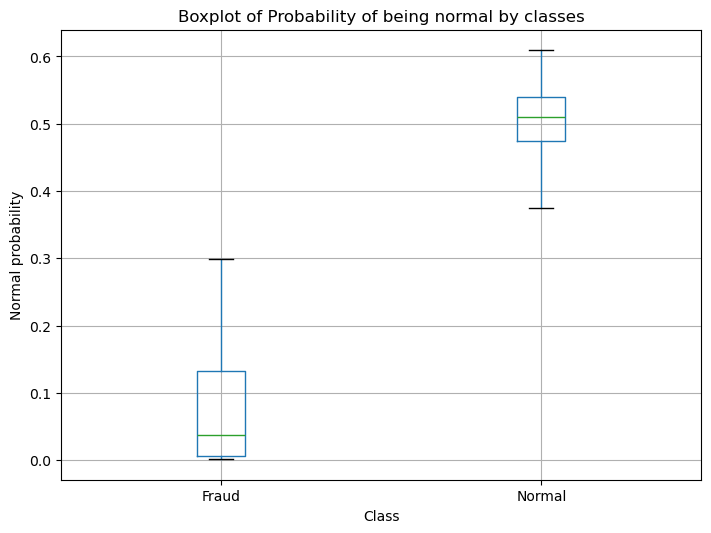

In [34]:
results = pd.DataFrame({})
results["pred"] = all_preds
results['class']=all_tar

results.boxplot(column='pred', by='class', figsize=(8, 6), showfliers=False)

# Ajouter des labels et un titre
plt.title("Boxplot of Probability of being normal by classes")
plt.suptitle("")  # Supprime le titre automatique de pandas
plt.xlabel("Class")
plt.ylabel("Normal probability")
plt.xticks(ticks=[1, 2], labels=['Fraud', 'Normal'])

# Afficher le graphique
plt.show()

### VAE - Reconstruction Loss

In [35]:
LR=1e-4
EPOCHS=10
BATCH_SIZE=256
LATENT_DIM=32

In [36]:
model = VAE(in_dim=30, hidden_dims=[128, 128], latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = LossVAE()

In [37]:
pbar = trange(EPOCHS, desc="Training")
for epoch in pbar:
    epoch_loss = 0

    for inputs, targets in trainloader:
        inputs = inputs.to(DEVICE)
        reconstructed, mu, logvar = model(inputs)
        loss = criterion(inputs, reconstructed, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss+=loss.item()

    epoch_loss = epoch_loss/len(trainloader)
    pbar.set_description(f"epoch : {epoch} ; loss : {epoch_loss}")

epoch : 9 ; loss : 8959.128872260362: 100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


In [38]:
val_preds = []
val_tar = []

model.eval()
with torch.no_grad():
    for val_batch, targets in tqdm(valloader, leave=True):
        val_batch, targets = val_batch.to(DEVICE), targets.to(DEVICE)
        reconstructed, mu, logvar = model(val_batch)
        loss = torch.sum((val_batch - reconstructed) ** 2, dim=1) -0.5 * torch.sum(1+logvar - mu**2 - logvar.exp(), dim=1)
        val_preds.append(-loss.cpu())
        val_tar.append(targets.cpu())

val_tar = torch.cat(val_tar)
val_preds = torch.cat(val_preds)

100%|██████████| 167/167 [00:00<00:00, 455.68it/s]


In [39]:
all_preds = []
all_tar = []

model.eval()
with torch.no_grad():
    for test_batch, targets in tqdm(testloader, leave=True):
        test_batch, targets = test_batch.to(DEVICE), targets.to(DEVICE)
        reconstructed, mu, logvar = model(test_batch)
        loss = torch.sum((test_batch - reconstructed) ** 2, dim=1) -0.5 * torch.sum(1+logvar - mu**2 - logvar.exp(), dim=1)
        all_preds.append(-loss.cpu())
        all_tar.append(targets.cpu())

all_tar = torch.cat(all_tar)
all_preds = torch.cat(all_preds)

score_vae = roc_auc_score(all_tar, all_preds)
print(f"ROC-AUC score: {score_vae}")

100%|██████████| 279/279 [00:00<00:00, 413.51it/s]

ROC-AUC score: 0.9314795653958798


In [40]:
test_p_values = (1 + torch.sum(all_preds.unsqueeze(1) >= val_preds, dim=1)) / (len(val_preds) + 1)
conserved = test_p_values>=THRESHOLD

vae_f1 = f1_score(all_tar, conserved)
vae_recall = recall_score(all_tar, conserved)
vae_precision = precision_score(all_tar, conserved)
vae_accuracy = accuracy_score(all_tar, conserved)

print(f"f1: {vae_f1}")
print(f"recall: {vae_recall}")
print(f"precision: {vae_precision}")
print(f"accuracy: {vae_accuracy}")

f1: 0.9947801518629702
recall: 0.990296450469708
precision: 0.9993046390509033
accuracy: 0.9896210780596051


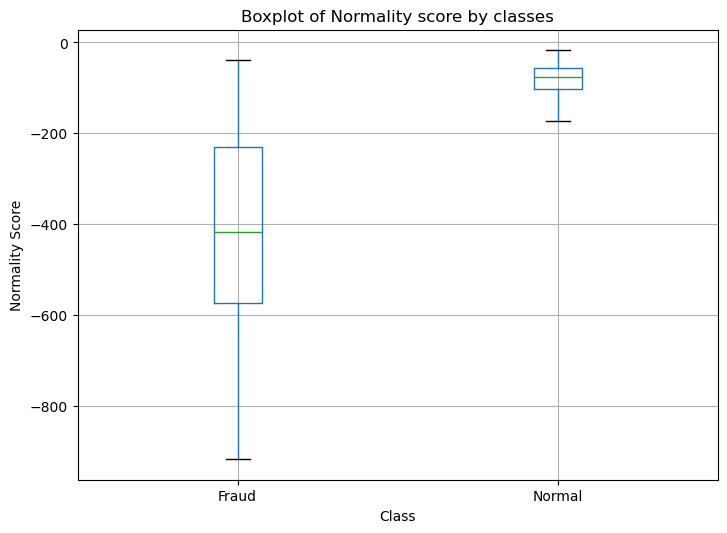

In [41]:
results = pd.DataFrame({})
results["pred"] = all_preds
results['class']=all_tar

results.boxplot(column='pred', by='class', figsize=(8, 6), showfliers=False)

# Ajouter des labels et un titre
plt.title("Boxplot of Normality score by classes")
plt.suptitle("")  # Supprime le titre automatique de pandas
plt.xlabel("Class")
plt.ylabel("Normality Score")
plt.xticks(ticks=[1, 2], labels=['Fraud', 'Normal'])

# Afficher le graphique
plt.show()

# Results Analysis: Considering a threshold of 1%

In [42]:
auc_scores = pd.DataFrame(
    {
        "Basic NN Supervised": [score_supervised, supervised_f1, supervised_accuracy, supervised_precision, supervised_recall],
        "Gradient Boosting": [score_catboost, boost_f1, boost_accuracy, boost_precision, boost_recall],
        "Deep SVDD": [score_dsvdd, dsvdd_f1, dsvdd_accuracy, dsvdd_precision, dsvdd_recall],
        "DROCC": [score_drocc, drocc_f1, drocc_accuracy, drocc_precision, drocc_recall],
        "VAE": [score_vae, vae_f1, vae_accuracy, vae_precision, vae_recall]
    },
    index=["ROC-AUC Scores: ", "F1 Scores: ", "Accuracy: ", "Precision: ", "Recall: "]
) 
auc_scores

,Basic NN Supervised,One-Class SVM SGD,Deep SVDD,DROCC,VAE
ROC-AUC Scores:,0.937028,0.505303,0.950257,0.954082,0.931480
F1 Scores:,0.993953,0.002650,0.995779,0.996367,0.994780
Accuracy:,0.987992,0.016755,0.991601,0.992767,0.989621
Precision:,0.999701,0.001327,0.999561,0.999689,0.999305
Recall:,0.988271,0.989362,0.992026,0.993067,0.990296
